<h1><center>Code for Group 6</center></h1>


<center>

#### <center> BNU-HKBU UNITED INTERNATIONAL COLLEGE
##### <center>Jiaxin Chen
<center>Beilan Lin (2130034021) Junxi Li (2130026073) Jiecheng Liao (2130026083) Yichen Yuan (2130026190) Shi He (2130026041)

## Outline
#### 1. Installation
#### 2. Import modules
#### 3. Read in data
#### 4. Gene expression enhancement
#### 5. Region annotation
#### 6. Characterize the intra-tumor heterogeneity
#### 7. TLS detection

### 1. Installation


#### 1.1 Initial

In [ ]:
git clone https://github.com/ffftuanxxx/Bio-HMTM
cd ./TESLA/TESLA_package/ #cmd / shell

In [ ]:
Use conda env create -f environment.yml # prepare environment, please do modify the prefix in environment.yml to your own location.

# step 2 activate the environment tesla2
conda activate tesla2

#### 1.3 setup

In [ ]:
python3 setup.py build
python3 setup.py install

### 2. Import significant modules

In [1]:
import os,csv,re, time
import pickle
import random
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy import stats
from scipy.sparse import issparse
import scanpy as sc
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import cv2
import TESLA as tesla
from IPython.display import Image

In [2]:
tesla.__version__

'1.2.2'

### 3. Read in data
The current version of TESLA requires three input data: 
<br>
1. The gene expression matrix(n by k): expression_matrix.h5;
<br>
2. Spatial coordinateds of samples positions.txt;
<br>
3. Histology image: histology.tif, can be tif or png or jepg.
<br>
The gene expreesion data can be stored as an AnnData object. AnnData stores a data matrix. X together with annotations of observations .obs, variables .var and unstructured annotations.

In [3]:
counts=sc.read("../data/sample_data.h5ad")

img=cv2.imread("../data/sample_H&E.jpg")

In [4]:
counts

AnnData object with n_obs × n_vars = 646 × 17344
    obs: 'new_x', 'new_y', 'pixel_x', 'pixel_y', 'array_x', 'array_y'

In [5]:
img.shape

(15872, 15872, 3)

### 4. Gene expression enhancement

#### 4.1 Preprocessing

In [6]:
resize_factor=1000/np.min(img.shape[0:2])
resize_width=int(img.shape[1]*resize_factor)
resize_height=int(img.shape[0]*resize_factor)
counts.var.index=[i.upper() for i in counts.var.index]
counts.var_names_make_unique()
counts.raw=counts
sc.pp.log1p(counts)
if issparse(counts.X):counts.X=counts.X.A

#### 4.2 Contour detection

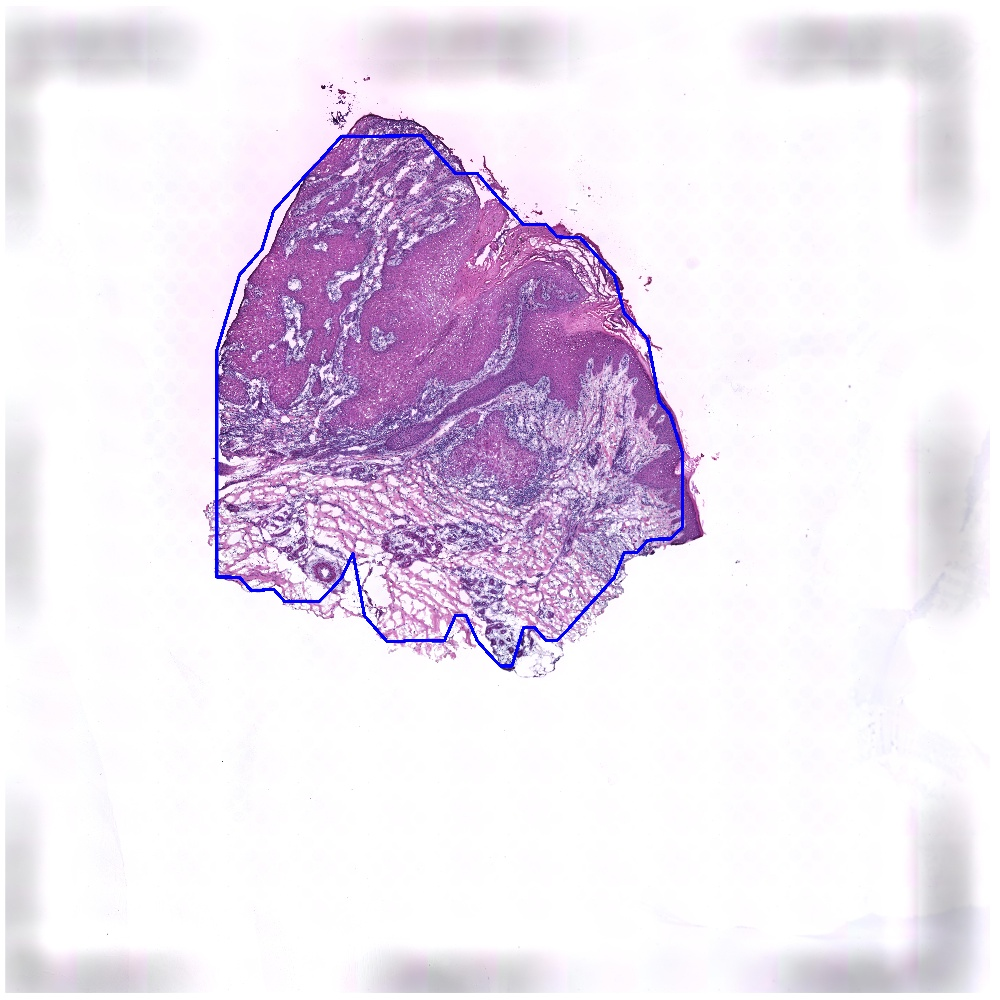

In [7]:
#-----------------1. Detect contour using cv2-----------------
cnt=tesla.cv2_detect_contour(img, apertureSize=5,L2gradient = True)

#-----------------2. Scan contour by x-----------------
spots=counts.obs.loc[:, ['pixel_x', 'pixel_y', "array_x", "array_y"]]

cnt=tesla.scan_contour(spots, scan_x=True, shape="hexagon")

#-----------------3. Scan contour by y-----------------
spots=counts.obs.loc[:, ['pixel_x', 'pixel_y', "array_x", "array_y"]]

cnt=tesla.scan_contour(spots, scan_x=False, shape="hexagon")

binary=np.zeros((img.shape[0:2]), dtype=np.uint8)
cv2.drawContours(binary, [cnt], -1, (1), thickness=-1)

cnt_enlarged = tesla.scale_contour(cnt, 1.05)
binary_enlarged = np.zeros(img.shape[0:2])
cv2.drawContours(binary_enlarged, [cnt_enlarged], -1, (1), thickness=-1)
img_new = img.copy()
cv2.drawContours(img_new, [cnt], -1, (255), thickness=50)
img_new=cv2.resize(img_new, ((resize_width, resize_height)))
cv2.imwrite('../results/cnt.jpg', img_new)
Image(filename='../results/cnt.jpg')

#### 4.3 Gene expression enhancement

In [8]:
# size of superpixel
res=50
# 
enhanced_exp_adata=tesla.imputation(img=img, raw=counts, cnt=cnt, genes=counts.var.index.tolist(), shape="None", res=res, s=1, k=2, num_nbs=10)

Total number of sudo points:  19882
Calculating spot 0
Calculating spot 1000
Calculating spot 2000
Calculating spot 3000
Calculating spot 4000
Calculating spot 5000
Calculating spot 6000
Calculating spot 7000
Calculating spot 8000
Calculating spot 9000
Calculating spot 10000
Calculating spot 11000
Calculating spot 12000
Calculating spot 13000
Calculating spot 14000
Calculating spot 15000
Calculating spot 16000
Calculating spot 17000
Calculating spot 18000
Calculating spot 19000
--- 46.79726767539978 seconds ---
Imputing spot 0
Imputing spot 1000
Imputing spot 2000
Imputing spot 3000
Imputing spot 4000
Imputing spot 5000
Imputing spot 6000
Imputing spot 7000
Imputing spot 8000
Imputing spot 9000
Imputing spot 10000
Imputing spot 11000
Imputing spot 12000
Imputing spot 13000
Imputing spot 14000
Imputing spot 15000
Imputing spot 16000
Imputing spot 17000
Imputing spot 18000
Imputing spot 19000


#### 4.4 Plot  gene expression image

##### Note: Please do the following 2 steps cell if your are in win system instead of run the 3rd cell directly.

In [ ]:
# # b'CD151' contains byte type data instead of pure strings.
# enhanced_exp_adata.var_names = [name.decode('utf-8') if isinstance(name, bytes) else name for name in enhanced_exp_adata.var_names]
# "CD151" in enhanced_exp_adata.var_names


True

In [ ]:
# [name for name in enhanced_exp_adata.var_names if "CD151" in name.decode('utf-8').upper()]
# print(type(enhanced_exp_adata.var_names[0]))

<class 'bytes'>


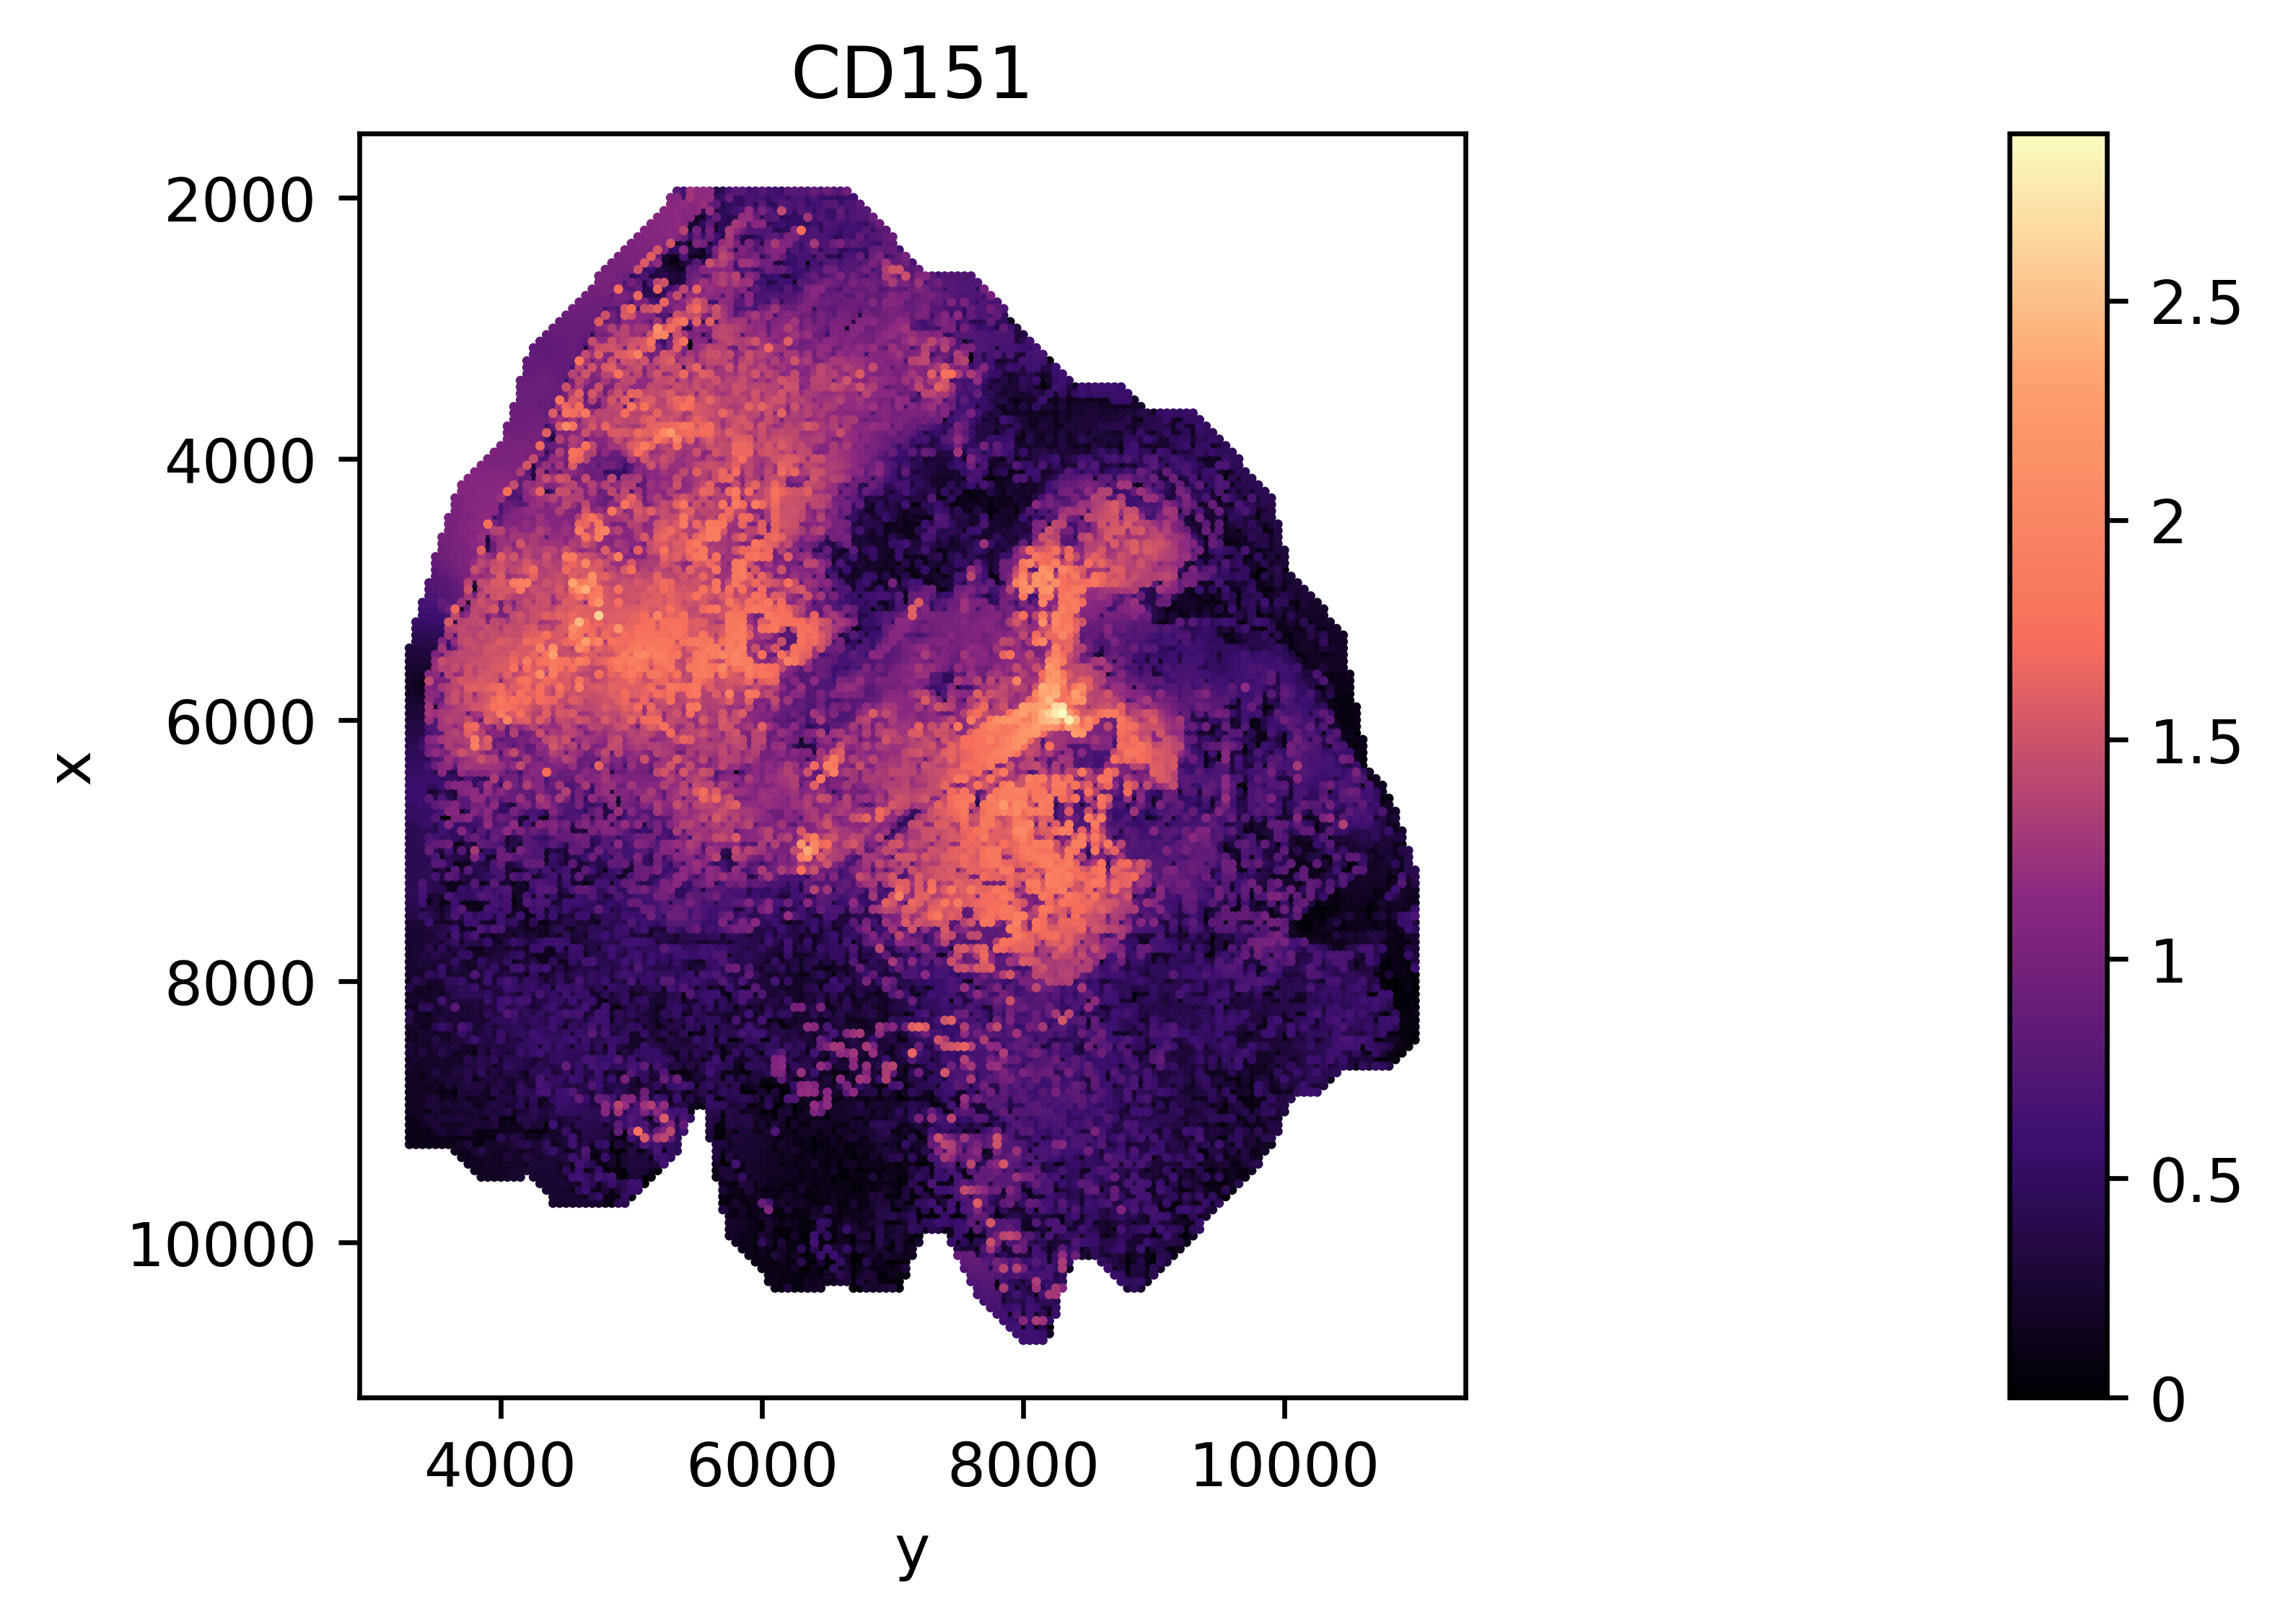

In [10]:
cnt_color = clr.LinearSegmentedColormap.from_list('magma', ["#000003",  "#3b0f6f",  "#8c2980",   "#f66e5b", "#fd9f6c", "#fbfcbf"], N=256)
g="CD151"
enhanced_exp_adata.obs[g]=enhanced_exp_adata.X[:,enhanced_exp_adata.var.index==g]
fig=sc.pl.scatter(enhanced_exp_adata,alpha=1,x="y",y="x",color=g,color_map=cnt_color,show=False,size=10)
fig.set_aspect('equal', 'box')
fig.invert_yaxis()
plt.gcf().set_dpi(600)
fig.figure.show()

#### 4.5 Save results

In [11]:
enhanced_exp_adata.write_h5ad("../results/enhanced_exp.h5ad")

### 5. Region annotation

#### 5.1 Target region annotation

Computing image band...
Computing gene band...
Running TESLA...
0 / 30 |  label num : 97 |  main clusters : 60  | feature loss : 3.8614988327026367  | spatial loss : 2.2918076515197754
--- 60.82564091682434 seconds ---
1 / 30 |  label num : 82 |  main clusters : 33  | feature loss : 3.8112316131591797  | spatial loss : 0.5777574777603149
--- 80.50724983215332 seconds ---
2 / 30 |  label num : 61 |  main clusters : 20  | feature loss : 3.6637184619903564  | spatial loss : 0.25664037466049194
--- 95.97449660301208 seconds ---
mainLabels 20 reached minLabels 30 .
Finding target clusters...
c_m:
[(3, 0.634570143512341), (8, 0.583210943626015), (9, 0.49985731037491254), (2, 0.4364831759511438), (6, 0.41532931066269774), (11, 0.28668049906044124), (10, 0.2833332720421252), (7, 0.22725742733768706), (16, 0.2265065677745667), (1, 0.18713292314086008), (4, 0.17551678537796608), (5, 0.15980471404758845), (13, 0.15467781495117996), (12, 0.12490259875197052), (14, 0.07512544038046888), (0, 0.0), (

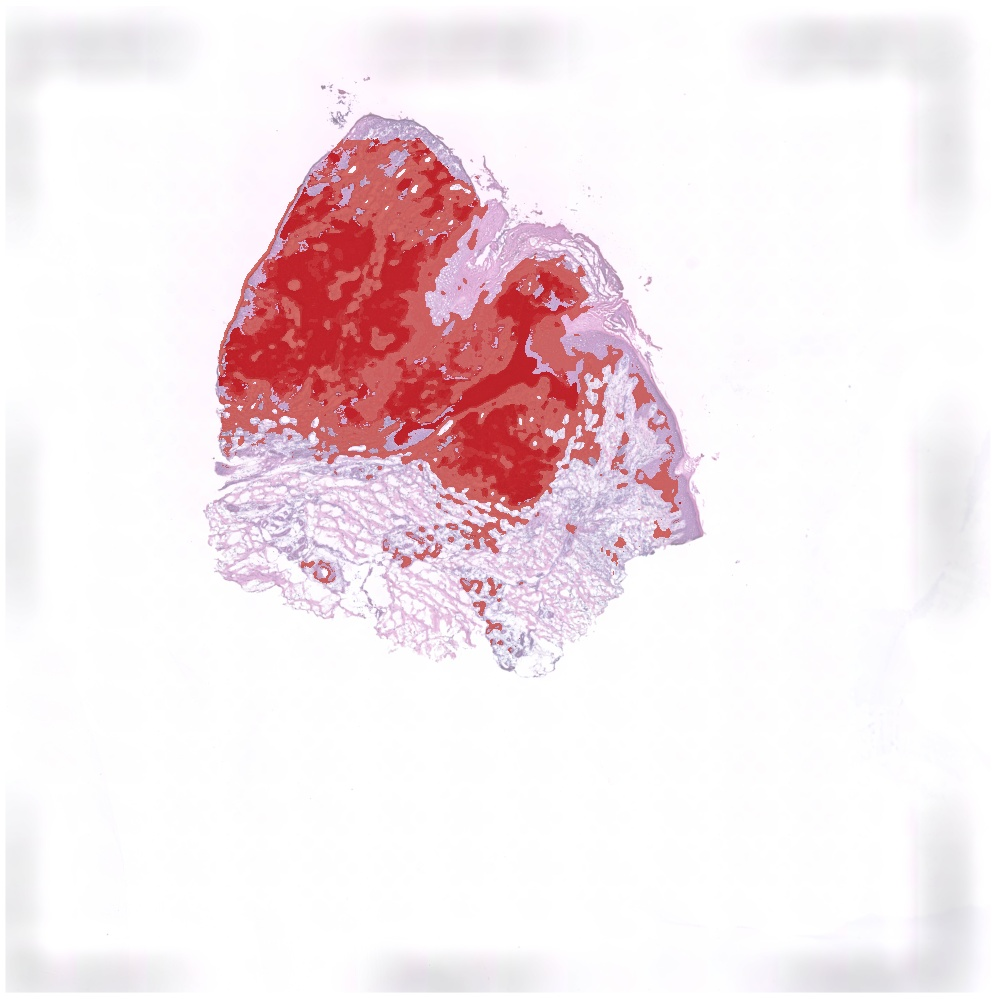

In [12]:
#Selected gene list
genes=['BUB1B', 'KIF1C','TOP2A', 'CD151', 'MMP10', 'PTHLH','FEZ1','IL24','KCNMA','INHBA','MAGEA4','NT5E','LAMC2','SLITRK6']
genes=list(set([i for i in genes if i in enhanced_exp_adata.var.index ]))
#target_size can be set to "small" or "large".
pred_refined, target_clusters, c_m=tesla.annotation(img=img, 
                                                    binary=binary,
                                                    sudo_adata=enhanced_exp_adata, 
                                                    genes=genes, 
                                                    resize_factor=resize_factor,
                                                    target_size="small")

ret_img=tesla.visualize_annotation(img=img, 
                              binary=binary, 
                              resize_factor=resize_factor,
                              pred_refined=pred_refined, 
                              target_clusters=target_clusters, 
                              c_m=c_m)

cv2.imwrite('../results/tumor.jpg', ret_img)
Image(filename='../results/tumor.jpg')

#### 5.2 Save results

In [13]:
#Save
np.save("../results/tumor_annotation.npy", pred_refined)
print("Target_clusters: ", target_clusters, "\n")
#Save the cluster density information
c_d={i[0]:i[1] for i in c_m[0:len(target_clusters)]}
print("Cluster_density : ", c_d)
with open('../results/tumor_annotation_c_d.pkl', 'wb') as f: pickle.dump(c_d, f)


Target_clusters:  [3, 8, 9, 2, 6] 

Cluster_density :  {3: 0.634570143512341, 8: 0.583210943626015, 9: 0.49985731037491254, 2: 0.4364831759511438, 6: 0.41532931066269774}


### 6. Characterize the intra-tumor heterogeneity

#### 6.1 Read in saved results

In [14]:
enhanced_exp_adata=sc.read("../results/enhanced_exp.h5ad")
pred_refined=np.load("../results/tumor_annotation.npy")
target_clusters=target_clusters
c_m = sorted(c_d.items(), key=lambda x: x[0])

#### 6.2 Leading edge detection

In [15]:
# ret_img=tesla.leading_edge_detection(img=img, 
#                                      pred_refined=pred_refined, 
#                                      resize_factor=resize_factor, 
#                                      target_clusters=target_clusters, 
#                                      binary=binary)

# cv2.imwrite('../results/leading_edge.jpg', ret_img)
# Image(filename='../results/leading_edge.jpg')

def cv2_detect_contour(img, 
    CANNY_THRESH_1 = 100,
    CANNY_THRESH_2 = 200,
    apertureSize=5,
    L2gradient = True,
    all_cnt_info=False):
    if len(img.shape)==3:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    elif len(img.shape)==2:
        gray=(img*((1, 255)[np.max(img)<=1])).astype(np.uint8)
    else:
        print("Image format error!")
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2,apertureSize = apertureSize, L2gradient = L2gradient)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)
    cnt_info = []
    cnts, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for c in cnts:
        cnt_info.append((c,cv2.isContourConvex(c),cv2.contourArea(c),))   
    #cnt_info = sorted(cnt_info, key=lambda c: c[2], reverse=True)
    #cnt=cnt_info[0][0]
    if cnt_info:
        cnt_info = sorted(cnt_info, key=lambda c: c[2], reverse=True)
        first_cnt = cnt_info[0]
    else:
        print("No contours found for this target_img.")
        
    if all_cnt_info:
        return cnt_info
    else:
        return cnt

In [16]:
def leading_edge_detection(img, pred_refined, resize_factor, target_clusters, binary):
	resize_width=int(img.shape[1]*resize_factor)
	resize_height=int(img.shape[0]*resize_factor)
	img_new = img.copy()
	img_new_resized = cv2.resize(img_new, (resize_width, resize_height))
	for t in target_clusters:
		target_img=(1*(pred_refined==t)).reshape(resize_height, resize_width)
		cnt_info=cv2_detect_contour((target_img==0).astype(np.uint8), apertureSize=5,L2gradient = True, all_cnt_info=True)
		cnt_info=list(filter(lambda x: (x[2] > 2000), cnt_info))
		for i in range(len(cnt_info)):
			cv2.drawContours(img_new_resized, [cnt_info[i][0]], -1, ([0, 0, 0]), thickness=2) #BGR
	return img_new_resized

ret_img= leading_edge_detection(img=img, 
                                     pred_refined=pred_refined, 
                                     resize_factor=resize_factor, 
                                     target_clusters=target_clusters, 
                                     binary=binary)

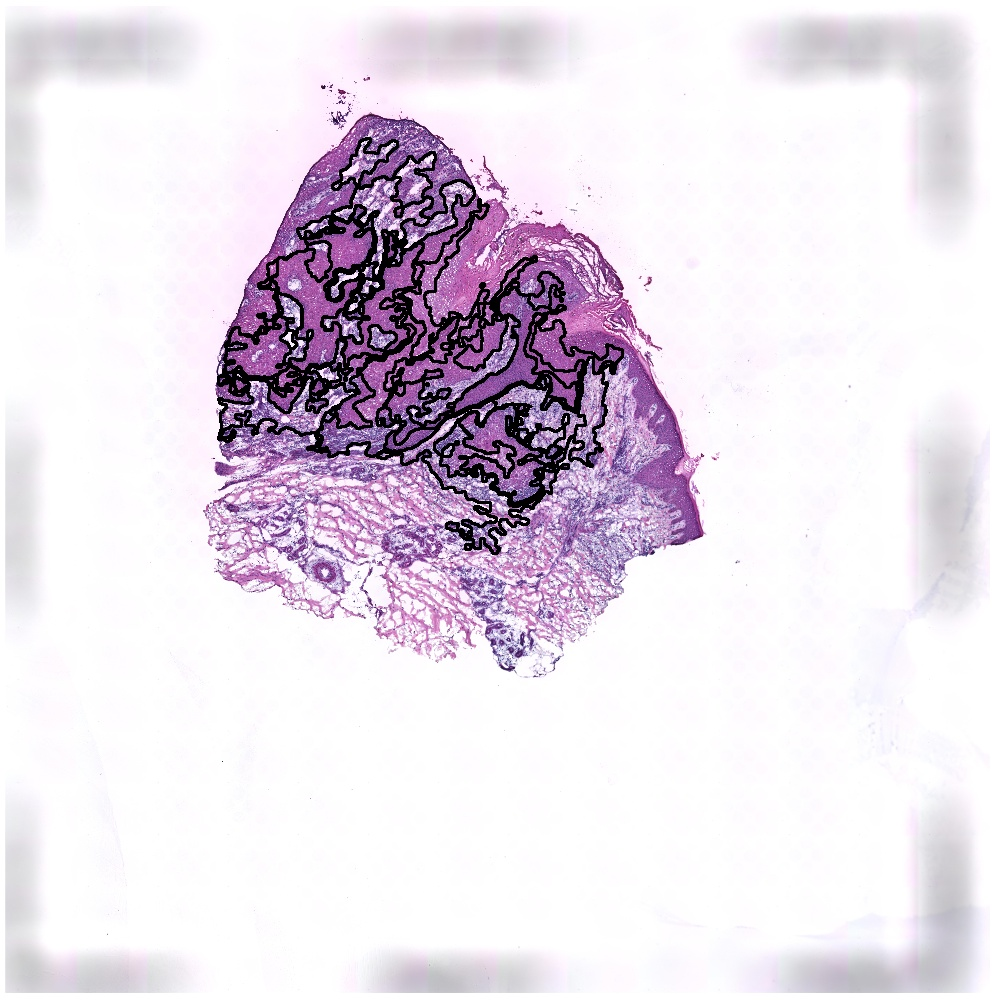

In [17]:
cv2.imwrite('../results/leading_edge.jpg', ret_img)
Image(filename='../results/leading_edge.jpg')

#### 6.3 Tumor edge and core separation

In [18]:
print(type(ret_img))
if isinstance(ret_img, np.ndarray):
    print(ret_img.shape, ret_img.dtype)


<class 'numpy.ndarray'>
(1000, 1000, 3) uint8


In [19]:
shrink_rate=0.8
res=50
enhanced_exp_adata.obs.index = enhanced_exp_adata.obs.index.astype(str)
binary_tumor, binary_core, core_edge_exp=tesla.tumor_edge_core_separation(img=img, 
                                                                           binary=binary,
                                                                           resize_factor=resize_factor, 
                                                                           pred_refined=pred_refined, 
                                                                           target_clusters=target_clusters, 
                                                                           sudo_adata=enhanced_exp_adata, 
                                                                           res=res, 
                                                                           shrink_rate=shrink_rate)

ret_img=tesla.plot_tumor_edge_core(img=img, 
                                   resize_factor=resize_factor, 
                                   binary=binary, 
                                   binary_tumor=binary_tumor, 
                                   binary_core=binary_core, 
                                   color_edge=[66, 50, 225], 
                                   color_core=[62, 25, 53])

ret_img = ret_img.astype(np.uint8)
cv2.imwrite('../results/core_edge.jpg', ret_img)


Running Connected Components ...
Running Select biggest Tumor region ...
Running Core and edge separation ...
Running Create Gene Expression adata for tumor edge vs. core ...


True

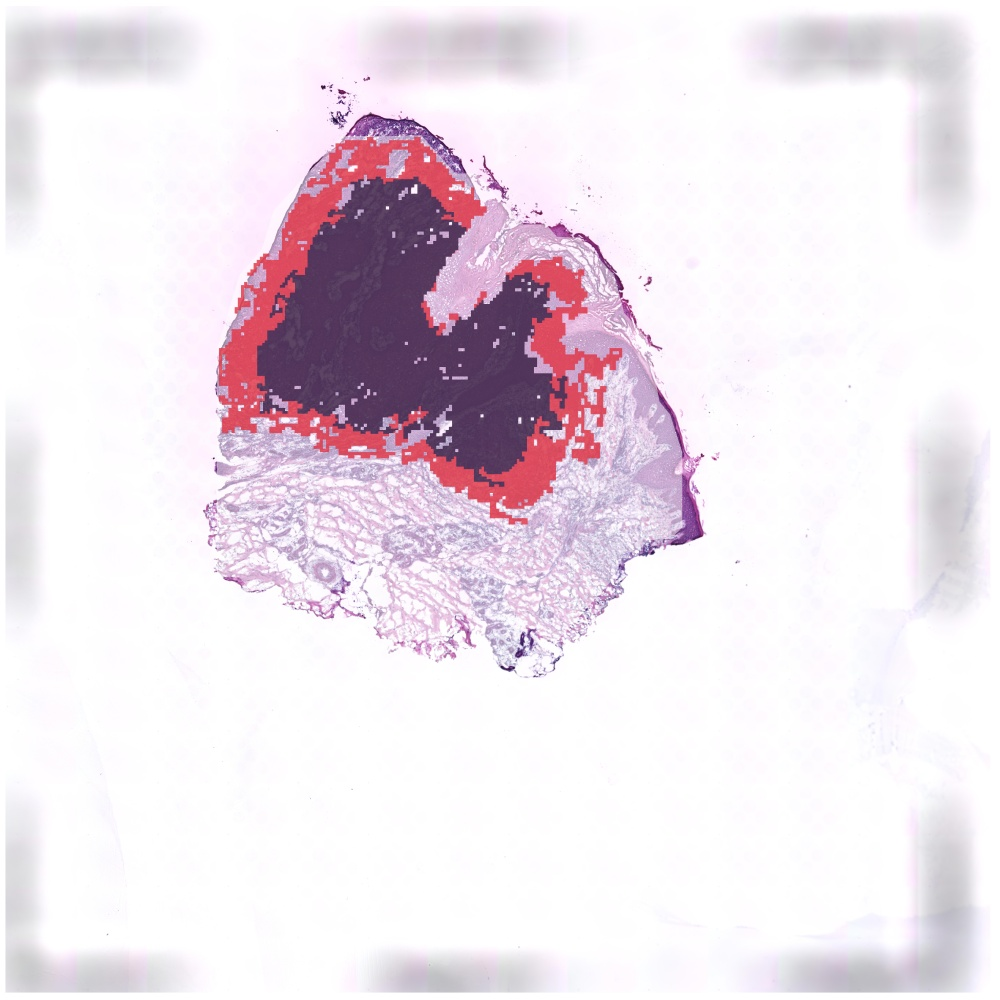

In [20]:
Image(filename='../results/core_edge.jpg')

#### 6.4. Core vs core DE analysis

In [21]:
df_core, df_edge=tesla.tumor_edge_core_DE(core_edge_exp)
df_edge_filtered=tesla.filter_DE_genes(df=df_edge, min_all_mean_exp=0.1, min_in_out_group_ratio=1, min_in_group_fraction=0.5, min_fold_change=1.2)
df_core_filtered=tesla.filter_DE_genes(df=df_core, min_all_mean_exp=0.1, min_in_out_group_ratio=1, min_in_group_fraction=0.5, min_fold_change=1.2)
df_edge_filtered

,edge_genes,in_group_fraction,out_group_fraction,in_out_group_ratio,in_group_mean_exp,out_group_mean_exp,fold_change,pvals_adj,all_mean_exp
PTGDS,PTGDS,0.763841,0.616993,1.238007,0.222306,0.109965,2.021606,1.217102e-78,0.150347
B3GALT4,B3GALT4,0.880725,0.742424,1.186282,0.158827,0.102384,1.551280,2.243424e-73,0.122673
CD37,CD37,0.632262,0.468163,1.350519,0.156263,0.072817,2.145964,6.015728e-69,0.102812
ANTXR2,ANTXR2,0.897813,0.712121,1.260758,0.173643,0.128009,1.356491,1.303062e-68,0.144413
C2,C2,0.845865,0.730341,1.158177,0.206131,0.140779,1.464215,2.414902e-57,0.164270
...,...,...,...,...,...,...,...,...,...
COMP,COMP,0.815448,0.808976,1.008000,0.236381,0.166019,1.423821,1.123242e-06,0.191311
DUSP2,DUSP2,0.766917,0.737438,1.039976,0.130193,0.095135,1.368508,1.628181e-05,0.107737
CCDC88B,CCDC88B,0.795625,0.732643,1.085966,0.151398,0.123496,1.225931,2.818407e-05,0.133526
TBC1D10C,TBC1D10C,0.566986,0.556387,1.019050,0.128214,0.085357,1.502098,2.169035e-04,0.100762


#### 6.5. Plot core/edge enriched genes

In [22]:
core_edge_exp.var_names = [v.decode('utf-8') if isinstance(v, bytes) else v for v in core_edge_exp.var_names]
for g in genes:
    print(g, g in core_edge_exp.var_names)


IL24 True
LAMC2 True
CD151 True
INHBA True
TOP2A True
MMP10 True
BUB1B True
NT5E True
FEZ1 True
SLITRK6 True
KIF1C True
PTHLH True


In [23]:
# Make sure it's not a view, but a real copy
core_edge_exp = core_edge_exp.copy()


In [36]:
cnt_color = clr.LinearSegmentedColormap.from_list('magma', ["#000003",  "#3b0f6f",  "#8c2980",   "#f66e5b", "#fd9f6c", "#fbfcbf"], N=256)
genes=["IGFBP2", "CD151"]
plot_dir="../results/"
tesla.plot_edge_core_enrichd_genes(img=img, 
                                   resize_factor=resize_factor,
                                   binary=binary, 
                                   binary_tumor=binary_tumor, 
                                   sudo_core_edge=core_edge_exp,
                                   genes=genes, 
                                   cnt_color=cnt_color, 
                                   plot_dir=plot_dir, 
                                   res=res)

### 6.6 Plot ome examples

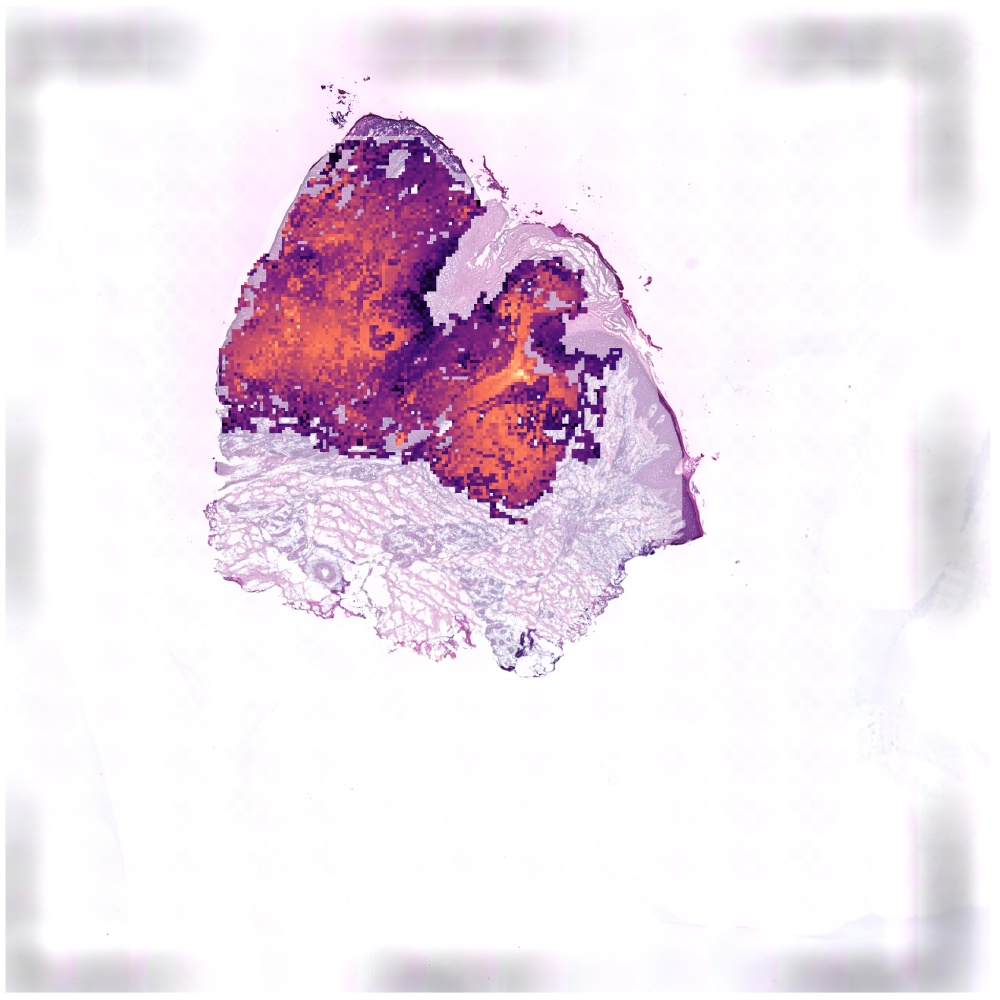

In [35]:
# Core enriched gene
Image(filename='../results/CD151.jpg')

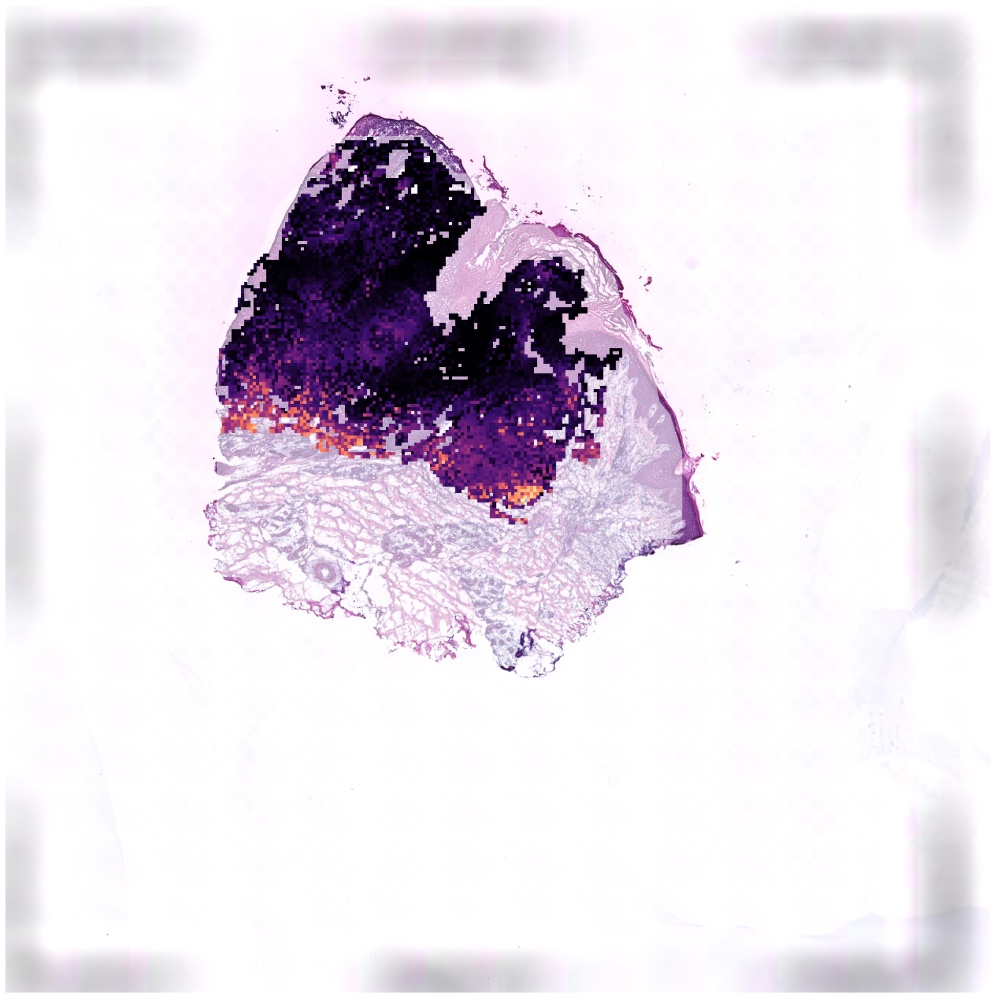

In [26]:
# Edge enriched gene
Image(filename='../results/CXCL12.jpg')

### 7. TLS detection

#### 7.1 Read in cell type annotations
##### Before runing TLS detection, please detect B, CD4+T, DC and CXCL13.

#### Here is the sample for 1 of our cell detected genes for 'pkl' file generation, others are performed in the same way.

In [29]:
#Save
np.save("../results/CXCL13_annotation.npy", pred_refined)
print("Target_clusters: ", target_clusters, "\n")
#Save the cluster density information
c_d={i[0]:i[1] for i in c_m[0:len(target_clusters)]}
print("Cluster_density : ", c_d)
with open('../results/CXCL13_annotation.pkl', 'wb') as f: pickle.dump(c_d, f)

Target_clusters:  [3, 8, 9, 2, 6] 

Cluster_density :  {2: 0.4364831759511438, 3: 0.634570143512341, 6: 0.41532931066269774, 8: 0.583210943626015, 9: 0.49985731037491254}


In [41]:
cnt_color = clr.LinearSegmentedColormap.from_list('red', ["#EAE7CC", '#BA0000'], N=256)
pred_refined1=np.load("../results/B_annotation.npy")
pred_refined2=np.load("../results/CD4+T_annotation.npy")
pred_refined3=np.load("../results/DC_annotation.npy")
pred_refined4=np.load("../results/CXCL13_annotation.npy")
pred_refined_list=[pred_refined1, pred_refined2, pred_refined3, pred_refined4]
#Read in cluster_density information
with open('../results/B_annotation.pkl', 'rb') as f: c_d1 = pickle.load(f)

with open('../results/CD4+T_annotation.pkl', 'rb') as f: c_d2 = pickle.load(f)

with open('../results/DC_annotation.pkl', 'rb') as f: c_d3 = pickle.load(f)

with open('../results/CXCL13_annotation.pkl', 'rb') as f: c_d4 = pickle.load(f)

cluster_density_list=[c_d1, c_d2, c_d3, c_d4]

#### 7.2 Calculate TLS score

In [42]:
cnt_color = clr.LinearSegmentedColormap.from_list("red", ["#01FF70", '#FF851B'], N=256)
num_required=1
tls_score=tesla.TLS_detection(pred_refined_list, cluster_density_list, num_required, cnt_color)
img_tls=tesla.plot_TLS_score(img, resize_factor, binary,tls_score, cnt_color)

#### 7.3 Plot TLS score

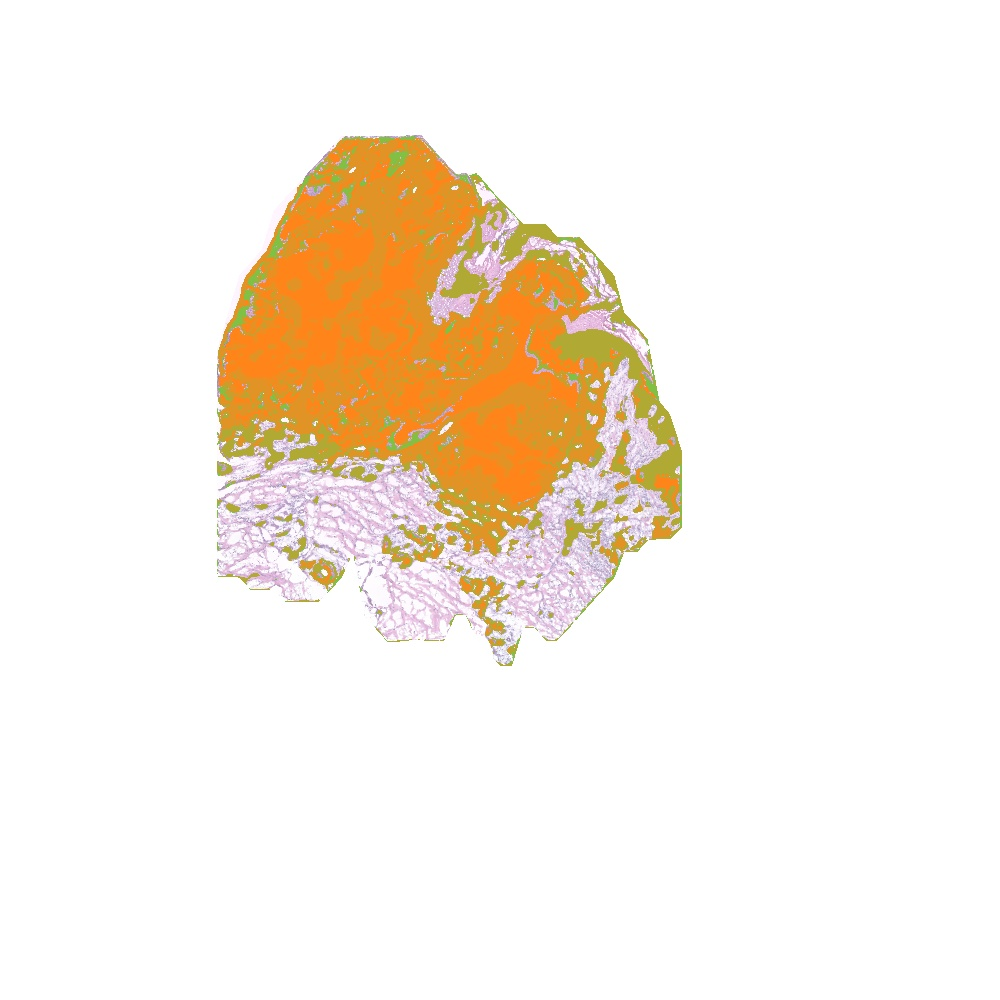

In [43]:
cv2.imwrite('../results/TLS_score.jpg', img_tls)
Image(filename='../results/TLS_score.jpg')

##### Acknowledgement
###### thank for the work of Author: Jian Hu,  Kyle Coleman, Edward B. Lee, Humam Kadara, Linghua Wang, Mingyao Li